In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
from tqdm.autonotebook import tqdm  # Fancy progress bars for our loops!
import intake
import gcsfs
import fsspec
import xesmf as xe
# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
col_url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(col_url)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [2]:
pd.set_option('display.max_rows', 250) # so that we can see all of the different experiments available

In [3]:
 # Different variable options : 
#'mrro' - runoff
#'snw' - SWE
 #hfls - latent heat
 # mrros - surface runoff
 # mrso - soil moisture
 # pr - precipitation
 # tas - mean daily air temperature
 # prra - rainfall rate
 # prsn - snowfall rate

variable_of_interest = 'mrro'

In [4]:
cat = col.search(experiment_id=['ssp585', 'historical', 'ssp126', 'ssp245', 'ssp370'],#, 'historical'], 
                 table_id='day',             
                 variable_id=variable_of_interest) 
# this is a hack just to get around the different grid_label strings
cat.df['grid_label']='gn'

In [5]:
future_slice = slice('2070','2099')
historical_slice = slice('1970','1999')

In [6]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False})

ds_dict = {}
for name, ds in tqdm(dset_dict.items()):
    # rename spatial dimensions if necessary
    if ('longitude' in ds.dims) and ('latitude' in ds.dims):
        ds = ds.rename({'longitude':'lon', 'latitude': 'lat'}) # some models labelled dimensions differently...
    ds = xr.decode_cf(ds) # temporary hack, not sure why I need this but has to do with calendar-aware metadata on the time variable
#     ds = ds.sel(time=time_slice) # subset the data for the time period of interest
    
    # drop redundant variables (like "height: 2m")
    for coord in ds.coords:
        if coord not in ['lat','lon','time']:
            ds = ds.drop(coord)
    
    # Add dataset to dictionary, selecting first member_id for each simulation since we'll just use
    # one ensemble member right now
    ds_dict[name] = ds.isel(member_id=0)

Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 61 group(s)


/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/tim

In [7]:
def calculate_change(historic, future, percentage=True):
    if percentage:
        return (future - historic)/(historic) * 100
    else:
        return future - historic

In [8]:
def annual_mean(ts):
    return ts.mean(dim='time')

In [9]:
def low_runoff(ts):
    return ts.resample(time='M').mean().groupby('time.year').min().mean(dim='year')

# regrid to a common grid

In [10]:
# specify the common grid based upon one of the higher resolution grids
common_grid_ds = xr.Dataset({'lat': (['lat'], ds_dict['CMIP.NCAR.CESM2.historical.day.gn'].lat.values),
                     'lon': (['lon'], ds_dict['CMIP.NCAR.CESM2.historical.day.gn'].lon.values)},)

change_dict = {}
for source_id in set(cat.df['source_id']):
    institution_id = list(set(cat.df['institution_id'][cat.df['source_id']==source_id].values))[0]
    if institution_id == 'EC-Earth-Consortium' or source_id == 'GFDL-ESM4' \
            or institution_id == 'CNRM-CERFACS' or source_id == 'HadGEM3-GC31-LL' \
    or source_id == 'BCC-ESM1' or source_id == 'MIROC-ES2L' or source_id == 'SAM0-UNICON' \
    or source_id == 'MPI-ESM1-2-HR': # this one just is doing something funky with its latitudes
        continue
    working_ds_historical = ds_dict['CMIP.{}.{}.historical.day.gn'.format(institution_id, source_id)][variable_of_interest]
    working_ds_future = ds_dict['ScenarioMIP.{}.{}.ssp585.day.gn'.format(institution_id, source_id)][variable_of_interest]
    
    # make the regridder for these files
    regridder = xe.Regridder(working_ds_historical, common_grid_ds, 'bilinear', reuse_weights=True) 
    
    # select future and historical periods
    runoff_historical = working_ds_historical.sel(time=historical_slice)
    runoff_future = working_ds_future.sel(time=future_slice)
    
    
    change_dict[source_id] = calculate_change(low_runoff(regridder(runoff_historical)), 
                                              low_runoff(regridder(runoff_future)))

Reuse existing file: bilinear_160x320_192x288.nc
Reuse existing file: bilinear_90x144_192x288.nc
Reuse existing file: bilinear_64x128_192x288.nc
Reuse existing file: bilinear_160x320_192x288.nc
Reuse existing file: bilinear_128x256_192x288.nc
Reuse existing file: bilinear_192x288_192x288.nc
Reuse existing file: bilinear_144x192_192x288.nc
Reuse existing file: bilinear_143x144_192x288.nc
Reuse existing file: bilinear_144x192_192x288.nc


In [11]:
# combine all data arrays in the dictionary into a single dataset
change_ds = xr.concat([change_dict[key] for key in change_dict.keys()], 
                      pd.Index(change_dict.keys(), name='gcm'))

In [ ]:
fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=(14,6),
                          subplot_kw=dict(projection=ccrs.Robinson()))
ax = axarr
ax.set_global()
ax.coastlines()
q = change_ds.mean(dim='gcm').plot(ax=ax, 
                                transform=ccrs.PlateCarree(), 
                                vmin=-100, vmax=100, 
                                cmap='RdBu')

ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
plt.title('Global patterns of change in low runnof',fontsize=16, ha='center');
plt.savefig('../figures/future_runoff_changes.png',dpi=100,bbox_inches='tight')

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


# Pull in ERA data to understand biases

In [97]:
ds = xr.open_zarr(fsspec.get_mapper('gcs://pangeo-era5/reanalysis/spatial-analysis'),
                  consolidated=True,
                  chunks='auto')

AttributeError: 'numpy.ndarray' object has no attribute 'set_global'

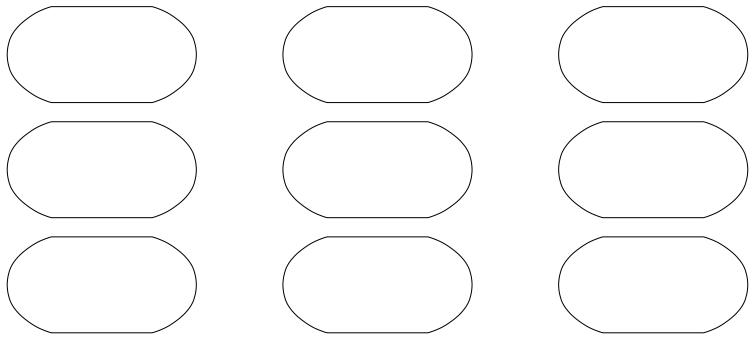

In [206]:
fig, axarr = plt.subplots(nrows=3, ncols=3, figsize=(14,6),
                          subplot_kw=dict(projection=ccrs.Robinson()))
for (i, source_id) in enumerate(change_dict.keys()):
    ax = axarr[i]
    ax.set_global()
    ax.coastlines()
    q = change_ds.sel(gcm=gcm).plot(ax=ax, 
                                    transform=ccrs.PlateCarree(), 
                                    vmin=-100, vmax=100, 
                                    cmap='RdBu', add_colorbar=False) # plot a colormap in transformed coordinates

    ax.add_feature(cartopy.feature.COASTLINE)
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-')
    plt.title('Patterns of global annual runnof change',fontsize=16, ha='center');
    # plt.savefig('../figures/future_runoff_changes.png',dpi=100,bbox_inches='tight')

#To-do list
* seasonal cycle (daily average for an average year within historical and future periods)
* function for each of these temporal metrics:
1. change in centroid of timing
1. change in lowest 30 day period magnitude
1. total deviation from the mean
1. duration of low flow
* function for each of these spatiotemporal metrics:
1. within a given basin what is the variability - to-do in this is figureing out shapefile masking for river basins